In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import json
import jax.numpy as np
import numpy as onp
import jax
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from timecast.learners import AR
from timecast.learners._ar import _ar_predict, _ar_batch_window
from timecast.utils.numpy import ecdf
from timecast.utils.losses import MeanSquareError
import torch
import matplotlib

plt.rcParams['figure.figsize'] = [20, 10]

import tqdm.notebook as tqdm

/home/dsuo/miniconda3/envs/toy_flood/lib/python3.7/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
from ealstm.gaip import FloodLSTM
from ealstm.gaip import FloodData
from ealstm.gaip.utils import MSE, NSE

from timecast.optim import SGD
from timecast.learners import AR

cfg_path = "/home/dsuo/src/toy_flood/ealstm/runs/run_2803_1428_seed215785/cfg.json"
flood_data = FloodData(cfg_path)
ea_data = pickle.load(open("../ealstm/runs/run_2803_1428_seed215785/ealstm_seed215785.p", "rb"))

In [3]:
LR_AR = 1e-5
AR_INPUT_DIM=32
AR_OUTPUT_DIM=1

results = {}
mses = []
nses = []
sgd = SGD(learning_rate=LR_AR, online=False)
ar = AR(input_dim=AR_INPUT_DIM,
        output_dim=AR_OUTPUT_DIM,
        window_size=flood_data.cfg["seq_length"],
        optimizer=sgd,
        fit_intercept=True,
        constrain=False
       )
for X, _, basin in tqdm.tqdm(flood_data.generator(), total=len(flood_data.basins)):
    ar._history=X[:flood_data.cfg["seq_length"]]
    sgd = SGD(learning_rate=LR_AR, online=False)
    
    # NOTE: difference in indexing convention, so need to pad one row
    X = np.vstack((X[flood_data.cfg["seq_length"]:], np.ones((1, X.shape[1]))))
    Y = np.array(ea_data[basin].qobs).reshape(-1, 1)
    
    Y_lstm = np.array(ea_data[basin].qsim).reshape(-1, 1)
    Y_target = Y - Y_lstm
    
    Y_ar = ar.predict_and_update(X, Y_target)
    
    Y_hat = Y_lstm + Y_ar
    
    mse = MSE(Y, Y_hat)
    nse = NSE(Y, Y_hat)
    results[basin] = {
        "mse": mse,
        "nse": nse,
        "count": X.shape[0],
        "avg_mse": np.mean(np.array(mses)),
        "avg_nse": np.mean(np.array(nses))
    }
    mses.append(mse)
    nses.append(nse)
    print(basin, mse, nse, np.mean(np.array(mses)), np.mean(np.array(nses)))

01022500 0.78019655 0.84153557 0.78019655 0.84153557
01031500 1.7253807 0.8163318 1.2527885 0.8289337
01047000 1.9251329 0.8196126 1.4769033 0.82582664
01052500 2.47221 0.8112283 1.72573 0.82217705
01054200 9.101436 0.6911881 3.2008712 0.79597926
01055000 5.8299932 0.6706251 3.6390584 0.7750869
01057000 1.038961 0.8585844 3.267616 0.7870151
01073000 0.9609808 0.8540349 2.9792867 0.7953926
01078000 0.8050049 0.8659175 2.7376997 0.8032287
01123000 1.0782064 0.7809831 2.5717504 0.8010041
01134500 1.8944969 0.76951647 2.510182 0.79814166
01137500 2.6222632 0.74212825 2.519522 0.7934739
01139000 0.7321793 0.7944304 2.382034 0.7935475
01139800 0.8304516 0.77227414 2.2712069 0.79202795
01142500 0.99963707 0.79753685 2.1864355 0.79239523
01144000 0.93520033 0.8097555 2.1082332 0.7934802
01162500 1.1819464 0.76756686 2.0537457 0.7919559
01169000 2.25865 0.7489689 2.0651293 0.7895677
01170100 1.8139589 0.7755859 2.0519097 0.7888319
01181000 1.7969049 0.8040406 2.0391595 0.7895923
01187300 3.2275

02479155 6.4096313 0.65864676 2.087841 0.7170211
02479300 2.1199932 0.75226724 2.0880322 0.7172308
02479560 1.4866958 0.834939 2.084474 0.71792734
02481000 8.6283045 0.65249276 2.1229672 0.71754247
02481510 3.0898476 0.7489134 2.1286213 0.7177258
04015330 2.9670827 0.55451256 2.1334963 0.7167769
04024430 0.5834113 0.7412746 2.124536 0.7169185
04027000 0.5388842 0.776042 2.1154232 0.71725833
04040500 0.35007203 0.8389396 2.1053355 0.7179537
04043050 0.85399085 0.80731 2.0982256 0.7184614
04045500 0.052846767 0.9390783 2.08667 0.71970785
04057510 0.037844475 0.95007896 2.0751595 0.72100204
04057800 0.47467583 0.78415877 2.0662184 0.7213549
04059500 0.13245161 0.87935567 2.055475 0.7222326
04063700 0.10783902 0.83851177 2.0447147 0.7228751
04074950 0.051865194 0.80366945 2.033765 0.723319
04105700 0.038949873 0.7661893 2.0228646 0.72355324
04115265 0.09302742 0.6666702 2.0123763 0.7232441
04122200 0.054631874 0.72555363 2.0017939 0.72325665
04122500 0.03986217 0.7745949 1.9912457 0.723532

06910800 1.6058352 0.8396044 2.0730414 0.7043381
06911900 2.2869084 0.80497754 2.0736835 0.70464027
06917000 2.7815654 0.76185584 2.075803 0.7048116
06918460 1.0648793 0.82715863 2.0727854 0.70517683
06919500 1.3727652 0.8318757 2.070702 0.7055539
06921070 2.465331 0.7756061 2.071873 0.70576173
06921200 6.0405765 0.62716997 2.0836148 0.7055292
07057500 0.9111036 0.6888727 2.080156 0.7054801
07060710 2.1118221 0.543018 2.0802493 0.7050023
07066000 2.0156887 0.58874595 2.0800598 0.70466137
07083000 0.11336338 0.97527117 2.0743093 0.7054526
07142300 0.039543275 -0.68411744 2.068377 0.70140135
07145700 1.6010423 0.7038437 2.0670185 0.70140845
07167500 8.359442 0.527417 2.0852573 0.70090413
07180500 2.1314893 0.6862422 2.085391 0.70086175
07184000 11.223471 0.63533974 2.1117253 0.70067286
07195800 2.5965858 0.59048045 2.1131186 0.7003563
07196900 8.389952 0.5611669 2.1311038 0.6999575
07197000 1.5961905 0.8111815 2.1295755 0.70027524
07208500 0.045976456 0.7374847 2.1236396 0.7003812
072610

14305500 14.623094 0.87446994 2.8137295 0.69638747
14306340 10.546742 0.83801347 2.8292575 0.6966719
14306500 4.8318214 0.8801244 2.8332705 0.6970395
14308990 2.2410662 0.7633387 2.832086 0.69717205
14309500 3.7648604 0.8629818 2.8339481 0.69750303
14316700 4.9716325 0.82025284 2.8382065 0.6977476
14325000 8.749631 0.85549027 2.849959 0.69806117
14362250 0.47088212 0.5924419 2.8452387 0.69785166
14400000 18.304146 0.90022916 2.87585 0.6982523
10259000 0.35828286 0.45558333 2.8708746 0.69777274
11124500 3.0242064 -0.17883086 2.8711772 0.6960437
11141280 0.9489742 0.41139764 2.8673935 0.6954834
11143000 3.7482405 0.85847354 2.8691244 0.6958035
11148900 7.2760057 0.7191076 2.877765 0.69584924
11151300 0.2092703 0.41301525 2.8725426 0.6952958
11176400 0.9740747 0.60040337 2.8688347 0.6951105
11230500 0.4284422 0.94829947 2.8640773 0.695604
11237500 2.206049 0.8991037 2.8627973 0.696
11264500 0.8043011 0.9281554 2.8588002 0.6964508
11266500 0.96345675 0.91590804 2.855127 0.6968761
11284400 

In [8]:
def rolling_mean(x, n):
    return pd.Series(x).rolling(window=n, min_periods=1).mean()

In [24]:
batch_size_results = {}
for i in tqdm.tqdm([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]):
    with open("../tmp/batch_{}.pkl".format(i), "rb") as f:
        batch_size_results["batch_size={}".format(i)] = pickle.load(f)

In [25]:
rolling_means = {}
for i, batch_size_result in batch_size_results.items():
    rolling_means[i] = rolling_mean([result["mse"].item() for result in batch_size_result.values()], 531)

In [26]:
rolling_means = pd.DataFrame.from_dict(rolling_means)

In [27]:
rolling_means["single_ar"] = rolling_mean(mses, 5311)

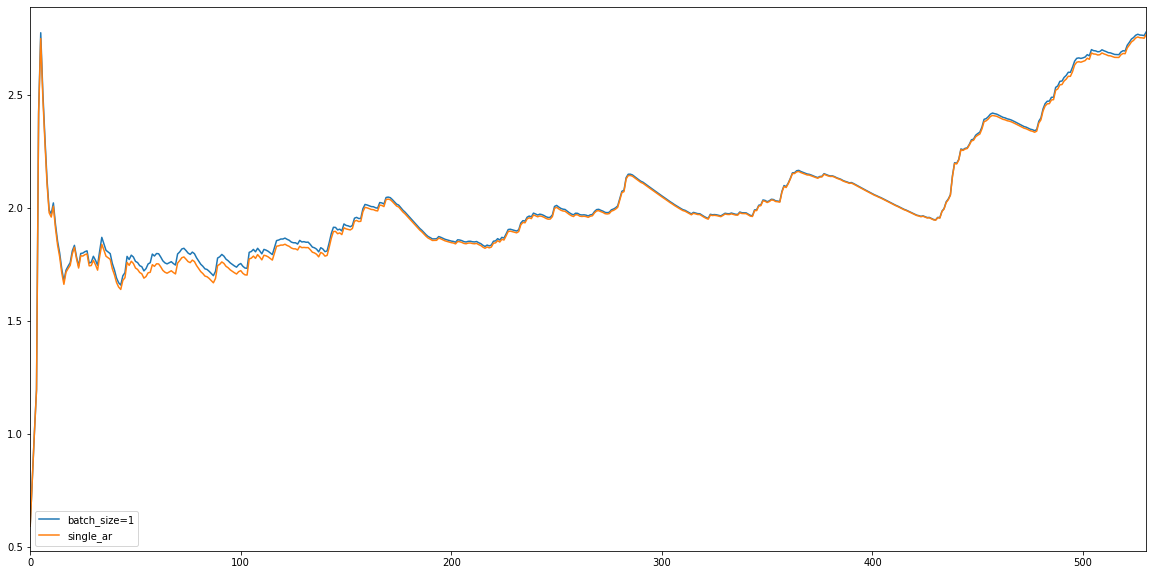

In [28]:
rolling_means[["batch_size=1", "single_ar"]].plot()